In [62]:
import pymongo
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import collections
import dateutil.parser
import datetime

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12, 8)

In [2]:
client = pymongo.MongoClient()

In [81]:
N_SETTINGS = 3
N_TASKS = 8

logs = list(client['autocomplete']['eventlogs'].find())

print(len(logs), 'event logs loaded.')
targets = set()

logs_by_session = collections.defaultdict(list)

for l in logs:
    logs_by_session[l['session']].append(l)
    targets.add(l['target'])

targets = dict(zip(targets, range(len(targets))))

print(len(logs_by_session), 'sessions.')

complete_sessions = []

for s, v in logs_by_session.items():
    settings = collections.Counter([l['setting'] for l in v])
    print('Session', s, 'has', len(v), 'complete tasks and settings', settings)

    if len(settings) == N_SETTINGS and len(v) == N_SETTINGS * N_TASKS:
        cs = []
        for setting in range(N_SETTINGS):
            st = []
            for t in v:
                if t['setting'] == setting:
                    st.append(t)
            cs.append(st)
        complete_sessions.append(cs)

print(len(complete_sessions), 'complete sessions.')

29 event logs loaded.
4 sessions.
Session 0.7732591308616995 has 1 complete tasks and settings Counter({1: 1})
Session 0.6826127972935271 has 24 complete tasks and settings Counter({1: 8, 2: 8, 0: 8})
Session 0.9887041588912289 has 1 complete tasks and settings Counter({2: 1})
Session 0.46666627573062536 has 3 complete tasks and settings Counter({0: 1, 2: 1, 1: 1})
1 complete sessions.


In [32]:
len(complete_sessions[0][0])

8

# Typing speed evolution

In [79]:
SETTINGS = [(0, "No autocomplete"), (1, "VSCode"), (2, "Pragmatic")]

def find_event(task, pred, first=True):
    ans = None
    for e in task['events']:
        if pred(e):
            ans = e
            if first:
                break
    return ans
        
def find_first(task, type):
    return find_event(task, lambda e: e['type'] == type)

def find_last(task, type):
    return find_event(task, lambda e: e['type'] == type, first=False)

def length(task):
    start = find_first(task, 'change')
    end = find_last(task, 'change')

    if start is None:
        print('Start not found in', task['events'][:10])
    
    ts_start = dateutil.parser.parse(start['timestamp'])
    ts_end = dateutil.parser.parse(end['timestamp'])
    return (ts_end - ts_start).seconds

def keystrokes(task):
    return sum(1 for e in task['events'] if e['type'] == 'change')

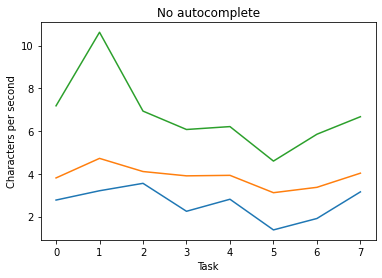

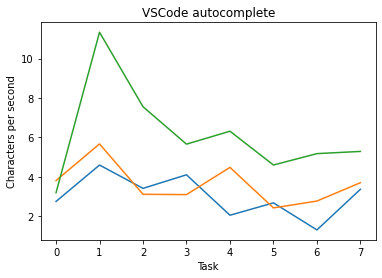

In [68]:
for (setting, title) in SETTINGS:
    plt.title(title)

    for session in complete_sessions:
        tasks = [t for t in session if t['setting'] == setting]
        tasks.sort(key=lambda r: r['timestamp'])
        speeds = [len(t['target']) / length(t) for t in tasks]
        plt.ylabel('Characters per second')
        plt.xlabel('Task')
        plt.plot(speeds)

    plt.show()

# Typing speed in different configurations

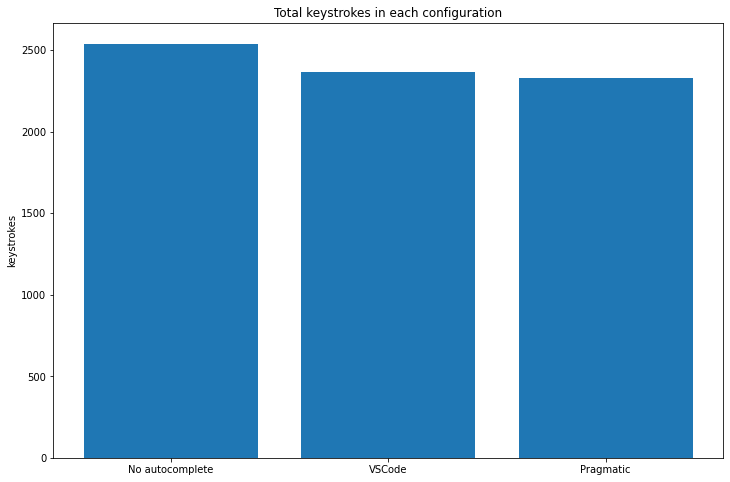

In [85]:
x, y = [], []

for (setting, title) in SETTINGS:
    x.append(title)
    y_i = 0.0
    for session in complete_sessions:
        tasks = session[setting]
        tasks.sort(key=lambda r: r['timestamp'])
        total_time = sum(keystrokes(t) for t in tasks)
        y_i += total_time
    y.append(y_i)

plt.title("Total keystrokes in each configuration")
plt.bar(x, y)
plt.ylabel('keystrokes')
plt.show()

# Relative typing speed in different configurations by subject and task

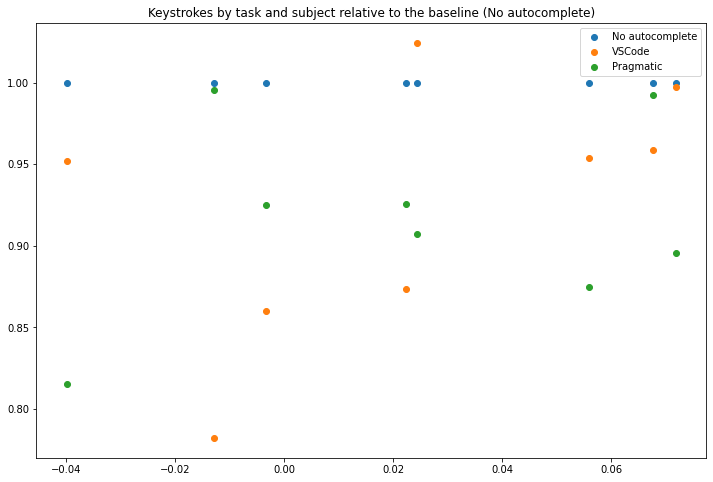

In [84]:
BASELINE = 0

x, ys = [], [[] for _ in range(N_SETTINGS)]

for u, session in enumerate(complete_sessions):
    for t in range(N_TASKS):
        x.append(u + np.random.normal() * 0.05)

        for (setting, title) in SETTINGS:
            l, l_base = keystrokes(session[setting][t]), keystrokes(session[BASELINE][t])
            ys[setting].append(l / l_base)

plt.title("Keystrokes by task and subject relative to the baseline ({})".format(SETTINGS[BASELINE][1]))

for setting, title in SETTINGS:
    plt.scatter(x, ys[setting], label=title)
    
plt.legend()
plt.show()

# Tasks

In [49]:
s = complete_sessions[0]

for t in range(N_TASKS):
    print('Task #{}:'.format(t))
    print(s[0][t]['target'])
    print('\n')

Task #0:
def start(self):
    if isinstance(self.bind_addr, tuple):
        host, port = self.bind_addr
        on_what = "%s:%s" % (host, port)
    else:
        on_what = "socket file: %s" % self.bind_addr
    if self.running:
        self.bus.log("Already serving on %s" % on_what)
        return
    self.interrupt = None


Task #1:
while len(pattern) < max:
    for ch1 in char1:
        for ch2 in char2:
            for ch3 in char3:
                if len(pattern) < max:
                    pattern.append(ch1)
                if len(pattern) < max:
                    pattern.append(ch2)
                if len(pattern) < max:
                    pattern.append(ch3)


Task #2:
import config
import numpy as np
class CMC:
    def __init__(self,fileName):
        f = open(fileName,'r')
        self.kernel = np.zeros([config.NSTATES*config.NACTIONS,config.NSTATES])
        self.matrix = np.zeros([config.NSTATES*config.NACTIONS,config.NSTATES])
        for iRow in xrange(config.NSTATES*c

# Raw log

In [78]:
SESSION = 0

for s in complete_sessions[SESSION]:
    for i, t in enumerate(s):
        print('Task #{}, setting "{}": started at {}, ended at {}, length: {:.1f}s'
              .format(
                  i,
                  SETTINGS[t['setting']][1],
                  find_first(t, 'change')['timestamp'],
                  find_first(t, 'end')['timestamp'],
                  length(t)))

Task #0, setting "No autocomplete": started at 2020-07-04T02:35:03.596Z, ended at 2020-07-04T02:35:43.721Z, length: 39.0s
Task #0, setting "VSCode": started at 2020-07-04T02:37:22.000Z, ended at 2020-07-04T02:38:00.634Z, length: 38.0s
Task #0, setting "Pragmatic": started at 2020-07-04T02:35:52.482Z, ended at 2020-07-04T02:36:36.138Z, length: 43.0s
